# Reaction-diffusion, metamodeling with 2 homogenous parameters

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r - \gamma u(t,x)), t\geq 0, x\in [0, 1]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in [0,1]^2
\end{cases}
$$

In all that follows,

- $\gamma=1$
- $D$ is a scalar in $[0.05, 1.]$ homogeneous in space and time
- $r$ is a scalar in $[0.05, 0.15]$ homogenous in space and time

**We want to build a metamodel and thus, learn the solution $u(t, x)$ of the above problem for all $D$ and for all $r$**



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


In [5]:
eqx_list = [
    [eqx.nn.Linear, 5, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1],
    [jax.nn.softplus]
]
key, subkey = random.split(key)

def input_transform(t_x, params):
    return jnp.concatenate([t_x, params["eq_params"]["D"], params["eq_params"]["r"]], axis=-1)


u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2, input_transform=input_transform)


In [6]:
init_nn_params = u.init_params()


Create a DataGenerator object

In [7]:
n = 500
nb = 500
nt = 500
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
)

In [8]:
method = "grid"
key, subkey = random.split(key)
np = 10000
param_batch_size = 32*32 # must be equal to omega_batch_size * time_batch_size !
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {"D":(0.05, 1.), "r":(0.05, 0.15)},
    method,
)

## Set up the initial condition

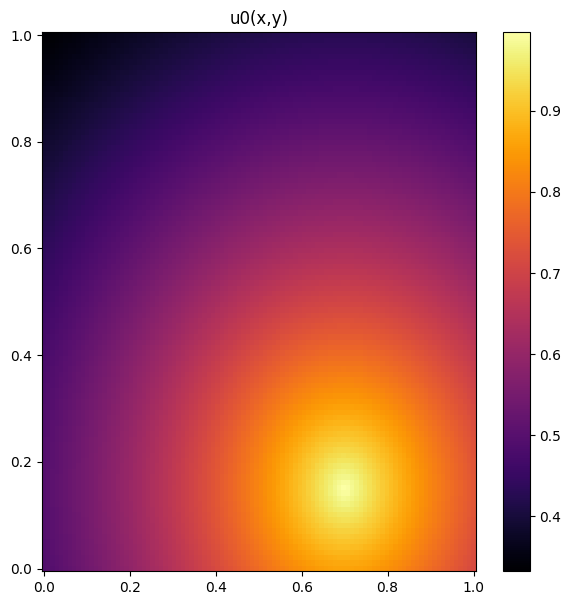

In [9]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init))

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)

### True model parameters

In [10]:
D = 0.5
g = 1.
r = 0.1


In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
}
init_params["eq_params"] = {"g":g, **param_train_data.get_batch()} # NOTE the additional batch is a dict 

The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

### Loss construction

In [12]:
fisher_dynamic_loss = jinns.loss.FisherKPP(Tmax=Tmax)

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition": 1 * Tmax, "boundary_loss":1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)


In [14]:
from jinns.data import append_param_batch

losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    append_param_batch(train_data.get_batch(), param_train_data.get_batch())
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 0.9749132990837097
Individual losses: {'boundary_loss': '0.47', 'dyn_loss': '0.48', 'initial_condition': '0.03', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params


In [16]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)


In [17]:
n_iter = 100000


In [18]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)


  0%|          | 0/100000 [00:00<?, ?it/s]

Iteration 0: loss value = 0.5250796675682068
Iteration 1000: loss value = 0.05196031183004379
Iteration 2000: loss value = 0.04868686571717262
Iteration 3000: loss value = 0.03623006492853165
Iteration 4000: loss value = 0.044225797057151794
Iteration 5000: loss value = 0.03980033099651337
Iteration 6000: loss value = 0.03872712701559067
Iteration 7000: loss value = 0.056685734540224075
Iteration 8000: loss value = 0.04984245076775551
Iteration 9000: loss value = 0.06153867393732071
Iteration 10000: loss value = 0.04550466686487198
Iteration 11000: loss value = 0.05036519095301628
Iteration 12000: loss value = 0.03767196461558342
Iteration 13000: loss value = 0.05577455833554268
Iteration 14000: loss value = 0.02442723885178566
Iteration 15000: loss value = 0.04110928997397423
Iteration 16000: loss value = 0.040558282285928726
Iteration 17000: loss value = 0.04079356789588928
Iteration 18000: loss value = 0.03937466815114021
Iteration 19000: loss value = 0.032949045300483704
Iteration 

### Results

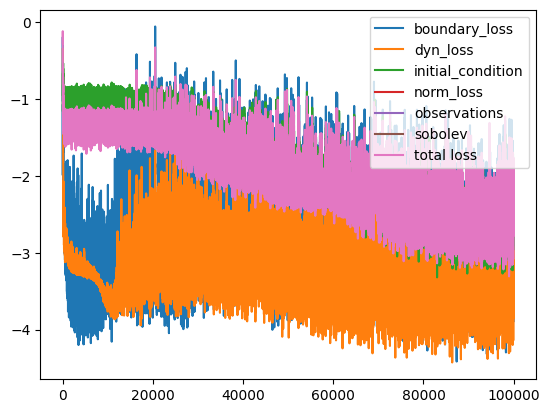

In [19]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solution learned by the PINN

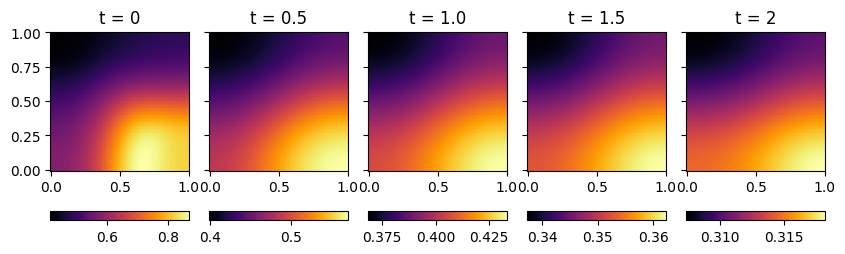

In [71]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time scale
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.1]), "r":jnp.array([0.1])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


## Compare the results with diffrax solver

In [66]:
from jinns.experimental import diffrax_solver, SpatialDiscretisation, laplacian
import diffrax

In [69]:
# --- PDE solution for true parameters
true_params = {
    "D": jnp.array(0.1),
    "r": jnp.array(0.1),
}

# Spatial discretisation
xmin, xmax = 0, 1
ymin, ymax = 0, 1
nx, ny = 70, 70

# init condition
mu_init = jnp.array([0.70, 0.15])

def gauss_ic(xy):
    return jnp.exp(-jnp.linalg.norm(xy - mu_init))

n_iter = 100

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, gauss_ic)

# Temporal discretisation
t0 = 0
Tmax = 2
times = jnp.linspace(t0, Tmax, 10)

# Tolerances for non-stiff problems
rtol = 1e-3
atol = 1e-6
# Tolerances for stiff problems (along with using float64)
# rtol = 1e-7
# atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=0.001
)

solver = diffrax.Tsit5()
max_steps = int(1e6)
saveat = (times,)

pde_control = {
    "xboundary": (xmin, xmax),
    "yboundary": (ymin, ymax),
    "nx": nx,
    "ny": ny,
    "ode_hyperparams": {
        "t0": 0,
        "t1": Tmax,
        "dt0": None,
        "y0": y0,
        "saveat": diffrax.SaveAt(ts=times),
        "stepsize_controller": stepsize_controller,
        "max_steps": max_steps,
        "solver": diffrax.Tsit5(),
    },
}


D = true_params["D"]
r = true_params["r"]
def vector_field(t, y, args):
    y = D * laplacian(y, True) + y * (r - 1. * y)
    # Impose a Dirichlet boundary condition
    #y = dirichlet_boundary_condition(y)
    return y

diffrax_solution = diffrax_solver(pde_control, vector_field)

[ 1  1  2  4  5  7  8 10]


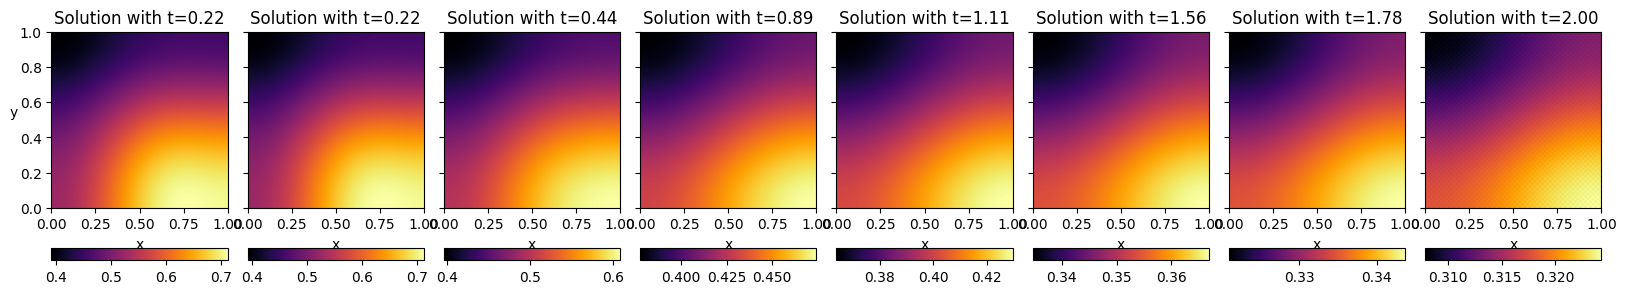

In [70]:
from mpl_toolkits.axes_grid1 import ImageGrid

nplot = 8
t_ind = jnp.floor(jnp.linspace(0, len(diffrax_solution.ts), nplot)).astype(int)
t_ind = t_ind.at[0].set(1)
print(t_ind)

fig = plt.figure(figsize=(20, 20 * nplot))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, nplot),
    axes_pad=0.2,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4,
)

for i, ax in enumerate(grid):
    ti = t_ind[i]
    im = ax.imshow(
        diffrax_solution.ys.vals[ti, :, :].T,
        origin="lower",
        extent=(xmin, xmax, ymin, ymax),
        aspect=(xmin - xmax) / (ymin - ymax),
        cmap="inferno",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y", rotation=0)
    ax.set_title(f"Solution with t={diffrax_solution.ts[ti]:.2f}")
    ax.cax.colorbar(im)
plt.show()